# TPT pipeline with ERA5 and S2S

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas
import matplotlib
from matplotlib import ticker
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LinearRegression,Lasso
from sklearn import tree
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs
from scipy.stats import genextreme
import functools

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils
%aimport tdmc_obj

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

# Set up experiment

Which tasks to do

In [7]:
compute_all_features_flag =           0
assemble_tpt_features_flag =          0
extreme_value_analysis_flag =         0
path_counting_flag =                  0
build_msm_flag =                      0
dga_flag =                            0
featset =                             1 # n, where this is the n'th set of features we've tried

In [8]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-09-03"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-10-15"),
                #"filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-10-15",),
                #"filename": "era5_features_tpt.nc",
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-09-04"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-10-15"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-10-15",),
                "filename": "s2s_features_tpt.nc",
            }),
        })    
    }),
    "results": dict({
        "shared": join(topic_dir, "results", "tpt_quantities", "2022-10-17", "shared"),
        "extval": join(topic_dir, "results", "tpt_quantities", "2022-10-17", "extval"),
        "pathcounting": join(topic_dir, "results", "tpt_quantities", "2022-10-17", "pathcounting"),
        "direct": join(topic_dir, "results", "tpt_quantities", "2022-10-17", "direct"),
        "dga": join(topic_dir, "results", "tpt_quantities", "2022-10-17", "dga"), # Further sub-directories to be specified below 
    })
})
dispdict = dict({
    "e5": dict({
        "color": "dodgerblue",
        "abbrv": "ERA5",
    }),
    "s2": dict({
        "color": "red",
        "abbrv": "S2S",
    }),
    "linear_model": dict({
        "color": "gray",
        "abborv": "Linear model",
    })
})

In [9]:
# Create the directories if they don't exist already

# Data folders
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)

# Results folders
for path in list(filedict["results"].keys()):
    if not exists(path): makedirs(filedict["results"][path], exist_ok=True)

## Read database and compute features. 

In [10]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [11]:
if compute_all_features_flag:
    obs2compute = [
        "time_observable", "ubar_observable",
        "temperature_observable", "heatflux_observable",
        "qbo_observable",
    ]
    for src in ["e5","s2"]:
        obs_dict = dict({obsname: [] for obsname in obs2compute})
        input_dir = filedict["data"][src]["traj"]["dir"]
        input_file_list = [join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".nc")]
        output_dir = filedict["data"][src]["feat_all"]["dir"]
        feat_strat.compute_all_features_nodask(
            src, input_file_list, output_dir, 
            obs2compute=obs2compute
        )

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [12]:
feat_all = dict()
for src in ["s2","e5"]:
    feat_all[src] = feat_strat.assemble_all_features(
        src,
        filedict["data"][src]["feat_all"]["dir"]
        )

Plot some climatological envelopes, as well as some hindcast ensembles from the same year 

[  0  30  61  91 122 153 181 212 242 273 303 334]


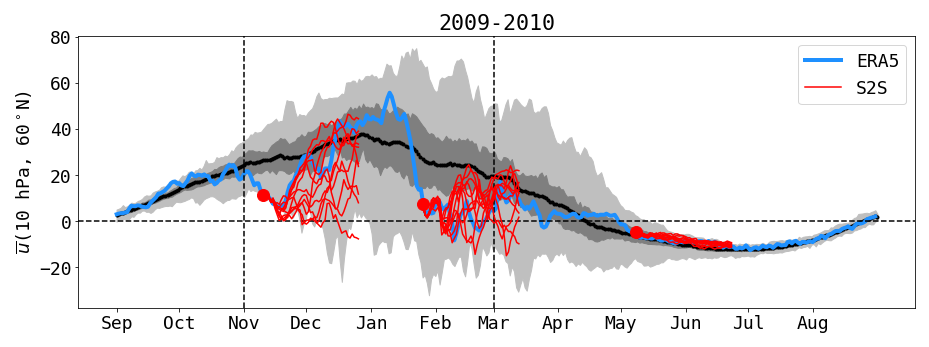

In [13]:
fig,ax = plt.subplots(figsize=(15,5))
fig.set_facecolor("white")
handles = []

year2plot = 2009
obs_group = "ubar_observable"
obs_name = "ubar_10_60"
obs_label = "$\overline{u}$(10 hPa, 60$^\circ$N)"
t_init_target_list = [70, 147.0, 250] # How many days into the season

cond_e5 = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)
cond_s2 = 1*(feat_all["s2"]["time_observable"].isel(t_sim=0).sel(feature="year_szn_start") == year2plot)

t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
xticks, xticklabels = feat_strat.generate_seasonal_xticks(t_szn_1year)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_title(f"{year2plot}-{year2plot+1}")

tpt_utils.plot_field_1d(
    feat_all["e5"][obs_group].sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(), 
    np.ones(feat_all["e5"][obs_group].t_sim.size), 
    feat_all["e5"]["time_observable"].sel(feature="t_szn").isel(t_init=0,member=0).to_numpy(),
    feat_name="", field_name=obs_label,
    fig=fig, ax=ax, nbins=365
)

h, = ax.plot(
    t_szn_1year,
    feat_all["e5"][obs_group].where(cond_e5,drop=True).sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(),
    color='dodgerblue', linewidth=4, label="ERA5"
)
handles += [h]
ax.legend(handles=handles)
fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_0"))

# Draw thresholds
u_thresh_list = np.arange(-52,1,4)
for uth in [0]: #u_thresh_list:
    ax.axhline(y=uth, color='black', linestyle='--')
ax.axvline(x=61, color='black', linestyle='--')
ax.axvline(x=181, color='black', linestyle='--')
fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_1"))


t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
for t_init_target in t_init_target_list:
    i_t_init = int(t_init_target / 3.5)
    for i_mem in range(feat_all["s2"]["time_observable"].member.size):
        x_ens, = (
            feat_all["s2"]["time_observable"].where(cond_s2,drop=True)
            .isel(t_init=i_t_init,member=i_mem)
            .sel(feature="t_szn").to_numpy()
        ),
        y_ens, = feat_all["s2"][obs_group].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature=obs_name).to_numpy(),
        h, = ax.plot(x_ens, y_ens, color='red', label="S2S")
        if i_mem == 0: 
            h = ax.scatter(x_ens[0], y_ens[0], color='red', marker='o', zorder=10, s=144)

handles += [h]
ax.legend(handles=handles)

fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_2"))

Plot some two-dimensional densities, at multiple time slices throughout the season.

# Assemble features for TPT.

Assemble and save the features with time delays. 

In [14]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [15]:
if assemble_tpt_features_flag:
    for src in ["s2","e5"]:
        feat_strat.assemble_tpt_features(feat_all[src], filedict["data"][src]["feat_tpt"]["dir"])

Reload them

In [16]:
feat_tpt = dict()
for src in ["s2","e5"]:
    feat_tpt[src] = xr.open_dataarray(join(filedict["data"][src]["feat_tpt"]["dir"], "features_tpt.nc"))

# Return time estimates: three methods 

In the following, we sweep through a number of SSW definitions, varying both the threshold and the season. 

In [17]:
sep1 = 0
oct1,nov1,dec1,jan1 = np.cumsum([monthrange(1901,m)[1] for m in [9,10,11,12]])
feb1,mar1,apr1 = jan1 + np.cumsum([monthrange(1902,m)[1] for m in [1,2,3]])
u_thresh_list = np.arange(-52,1,4)
t_thresh_list = np.array([
    [oct1, apr1],
    [nov1, mar1],
    [oct1, mar1],
])[:2]
t_thresh_string_list = [
    "Oct-Mar", "Nov-Feb", 
]
np.save(join(filedict["results"]["shared"], "u_thresh_list"), u_thresh_list)
np.save(join(filedict["results"]["shared"], "t_thresh_list"), u_thresh_list)

## Method 1: extreme value theory

In [18]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [19]:
if extreme_value_analysis_flag:
    feat_strat.extreme_value_analysis(t_thresh_list, feat_tpt, filedict["results"]["extval"])

## Plot results for extreme values

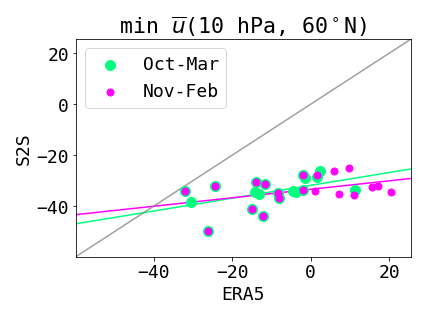

In [20]:
fig,ax = plt.subplots()
fig.set_facecolor("white")
xlim = np.inf*np.array([1,-1])

itth_list = [0,1,2]
sizes = [100, 49, 9]
zorders = [1, 2, 3]
colors = ['springgreen', 'magenta', 'black']

handles = []
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    extval_stats = pickle.load(open(join(filedict["results"]["extval"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
    fyidx = dict({
        "e5": np.where(np.in1d(extval_stats["e5"]["fall_years"], extval_stats["s2"]["fall_years"])),
        "s2": np.where(np.in1d(extval_stats["s2"]["fall_years"], extval_stats["e5"]["fall_years"]))
    })
    fy_common = extval_stats["e5"]["fall_years"][fyidx["e5"]]
    # Plot minimum S2S vs minimum E5
    xdata = extval_stats["e5"]["umin"][fyidx["e5"]]
    ydata = extval_stats["s2"]["umin"][fyidx["s2"]]
    xlim = [min(xlim[0], xdata.min(), ydata.min()) - 5, max(xlim[1], xdata.max(), ydata.max()) + 5]
    h = ax.scatter(xdata, ydata, s=sizes[i_tth], color=colors[i_tth], marker='o', zorder=zorders[i_tth], label=t_thresh_string_list[i_tth])
    handles += [h]
# Plot the linear model
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    extval_stats = pickle.load(open(join(filedict["results"]["extval"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
    intercept,slope = extval_stats["linear_model"]["coeffs"]
    ax.plot(np.array(xlim), intercept + slope*np.array(xlim), color=colors[i_tth], zorder=-1)

ax.set_title(r"min $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_xlabel("ERA5")
ax.set_ylabel("S2S")
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.plot(xlim, xlim, color='gray', zorder=-1, alpha=0.75)
ax.legend(handles=handles)

fig.savefig(join(filedict["results"]["extval"], "umin_s2_vs_e5"), bbox_inches="tight")


## Method 2: count paths from each initialization

In [21]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [22]:
if path_counting_flag:
    for i_tth in range(len(t_thresh_list)):
        t_thresh = t_thresh_list[i_tth]
        rate_e5,rate_s2 = feat_strat.path_counting_rates(feat_all, feat_tpt, t_thresh, u_thresh_list, min_spread_time=15)
        rate_e5.to_netcdf(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
        rate_s2.to_netcdf(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

## Plot results

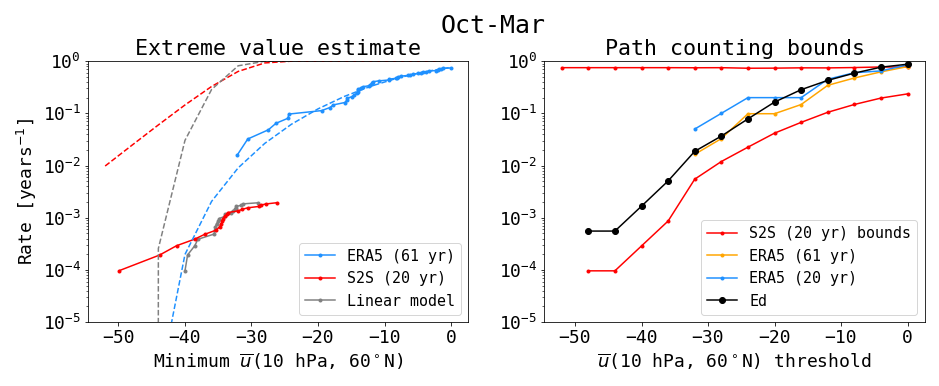

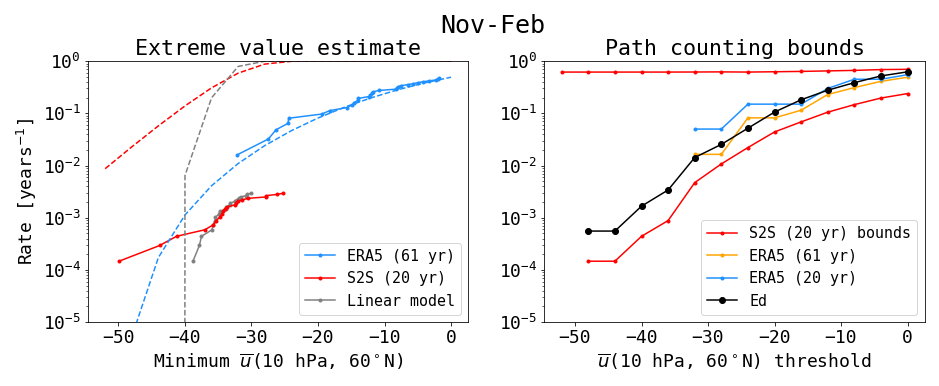

In [23]:
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    extval_stats = pickle.load(open(join(filedict["results"]["extval"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
    rate_e5 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
    rate_s2 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

    fig,axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)
    fig.set_facecolor("white")
    axes[1].yaxis.set_tick_params(labelbottom=True)

    # First plot: extreme values
    ax = axes[0]
    labels = {"e5": "ERA5 (61 yr)", "s2": "S2S (20 yr)", "linear_model": "Linear model"}
    zorders = {"e5": 0, "s2": 1, "linear_model": -1}
    handles = []
    for src in ["e5","s2","linear_model"]:
        idx, = np.where(extval_stats[src]["umin"] < 0)
        order = np.argsort(extval_stats[src]["umin"][idx])
        h, = ax.plot(
            extval_stats[src]["umin"][idx][order], extval_stats[src]["rate_lower"][idx][order], 
            color=dispdict[src]["color"],
            marker='.', label=labels[src], zorder=zorders[src]
        ) 
        handles += [h]
        # Also the GEV fit
        shp,loc,scale = [extval_stats[src]["gevpar"][v] for v in ["shp","loc","scale"]]
        h, = ax.plot(
            u_thresh_list, genextreme.sf(-u_thresh_list,shp,loc=loc,scale=scale),
            linestyle='--', color=dispdict[src]["color"]
        )


    ax.legend(handles=handles, fontsize="small", loc="lower right")
    ax.set_xlabel("Minimum $\overline{u}$(10 hPa, 60$^\circ$N)")
    ax.set_ylabel("Rate [years$^{-1}$]")
    ax.set_yscale("log")
    ax.set_title("Extreme value estimate")

    # Second plot: rates
    ax = axes[1]
    handles = []
    rate_s2 = rate_s2.where(rate_s2 > 0)
    #colors = ["red", "purple", "orange"]
    ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='.')
    h, = ax.plot(
        rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
        color="red", marker='.', label=r"S2S (20 yr) bounds"
    )
    handles += [h]
    # Additionally plot ERA5 only
    h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), color="orange", marker='.', label="ERA5 (61 yr)")
    handles += [h]
    h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), color="dodgerblue", marker='.', label="ERA5 (20 yr)")
    handles += [h]

    # Additionally plot Ed's estimate
    h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="Ed")
    handles += [h]

    ax.set_yscale("log")
    ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
    ax.legend(handles=handles, fontsize="small")
    ax.set_title("Path counting bounds")
    ax.set_ylim([1e-5,1])

    fig.subplots_adjust(top=0.85)
    fig.suptitle(t_thresh_string_list[i_tth], y=0.98, fontsize=25)

# Method 3: DGA

In [24]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
reload(tdmc_obj)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

Algorithmic parameters

In [25]:
max_delay_list = [1, 2, 5, 10, 15]
num_clusters_list = [50, 100, 150]
clust_bndy_choice = "half"

In [26]:
for max_delay in max_delay_list[::-1]:
    print(f"----------- Time delay {max_delay} -------------")
    for num_clusters in num_clusters_list:
        print(f"-------- {num_clusters} clusters ------------")
        resultdir = join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}")
        os.makedirs(resultdir, exist_ok=True)
        
        if build_msm_flag:
            msm_feature_names = [f"ubar_10_60_delay{d}" for d in np.arange(max_delay)] 
            szn_stats_e5,msm_info = feat_strat.build_msm(
                max_delay, feat_all, feat_tpt, msm_feature_names, resultdir, km_seed=43, num_clusters=num_clusters, 
            )

            szn_stats_e5.to_netcdf(join(resultdir, "szn_stats_e5.nc"))

        if dga_flag:
            szn_stats_e5 = xr.open_dataset(join(resultdir, "szn_stats_e5.nc"))
            msm_info = pickle.load(open(join(resultdir, "msm_info"), "rb"))
            feat_strat.dga_from_msm(
                msm_info, feat_tpt, szn_stats_e5, t_thresh_list, 
                u_thresh_list, resultdir, clust_bndy_choice)

        

----------- Time delay 15 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
----------- Time delay 10 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
----------- Time delay 5 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
----------- Time delay 2 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
----------- Time delay 1 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------


In [27]:
def softlogit(q):
    eps = 1e-10
    qlogit = np.log(np.maximum(q, eps) / np.maximum(1-q, eps))
    qlogit = qlogit.where((q > eps)*(q > 1-eps))
    return qlogit


In [ ]:

# Evaluate the specific choice of clustering
tau_max = 20
for t_thresh in t_thresh_list:
    qp_lim_err = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "max_delay": max_delay_list, "num_clusters": num_clusters_list},
        dims=["u_thresh","max_delay","num_clusters"],
        data=np.nan
    )
    for u_thresh in u_thresh_list:
        print(f"-------------- U thresh {u_thresh}-------------------")
        feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
        ab_tag_s2 = feat_strat.ab_test(feat_tpt["s2"])
        cej_s2 = feat_strat.cotton_eye_joe(feat_tpt["s2"], ab_tag_s2, "timesteps")
        qp_limited_s2 = 1.0*(cej_s2.sel(sense="until",state="B") <= tau_max).sel(t_sim=cej_s2["t_sim"].values[-1]-tau_max-3)
        comm_s2 = feat_strat.estimate_empirical_committor(cej_s2)
        for max_delay in max_delay_list[::-1]:
            #print(f"----------- Time delay {max_delay} -------------")
            for num_clusters in num_clusters_list:
                #print(f"-------- {num_clusters} clusters ------------")
                resultdir = join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}")
                tau_pmf = pickle.load(open(join(
                    filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                    f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))["tau_pmf"]
                msm_info = pickle.load(open(join(
                    filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                    f"msm_info"), "rb"))
                # Calculate an integrated error metric 
                tau_leq46 = [np.nansum(tau_pmf[i][:tau_max], axis=0) for i in range(len(tau_pmf))]
                qp_limited_dga = feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], tau_leq46).sel(t_sim=cej_s2["t_sim"].values[-1]-tau_max-3)
                print(f"dga tpmf: fracfinite = {np.mean(np.isfinite(qp_limited_dga.values))}")
                print(f"min and max: {np.nanmin(qp_limited_dga.values)}, {np.nanmax(qp_limited_dga.values)}")
                qplog = np.log(qp_limited_dga.where(qp_limited_dga > 0))
                qpilog = np.log((1-qp_limited_dga).where(qp_limited_dga < 1))
                qp_lim_err.loc[dict(u_thresh=u_thresh,max_delay=max_delay,num_clusters=num_clusters)] = (
                    -(qp_limited_s2 * qplog + (1-qp_limited_s2) * qpilog).mean()
                )                #qp_lim_err.loc[dict(u_thresh=u_thresh,max_delay=max_delay,num_clusters=num_clusters)] = (
                #    ((qp_limited_dga - qp_limited_s2)**2).mean()
                #)

    qp_lim_err.to_netcdf(join(filedict["results"]["dga"], f"qp_lim_err_{t_thresh[0]}-{t_thresh[1]}.nc"))

In [104]:
!ls {filedict["results"]["dga"]}/*qp_lim*.nc

/scratch/jf4241/ecmwf_data/results/tpt_quantities/2022-10-17/dga/qp_lim_err_30-212.nc
/scratch/jf4241/ecmwf_data/results/tpt_quantities/2022-10-17/dga/qp_lim_err_61-181.nc


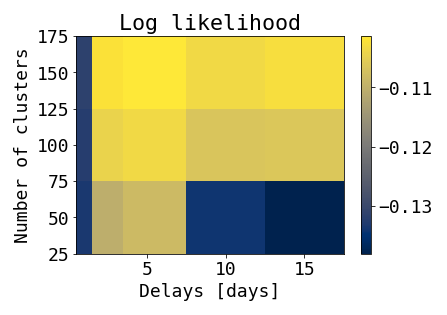

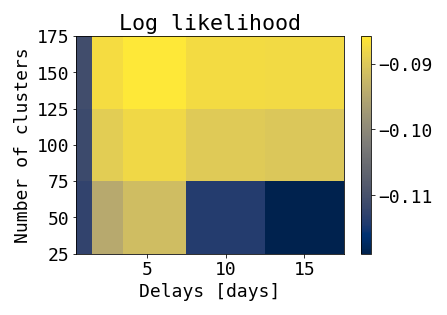

In [28]:
for t_thresh in t_thresh_list:
    qp_lim_err = xr.open_dataarray(join(filedict["results"]["dga"], f"qp_lim_err_{t_thresh[0]}-{t_thresh[1]}.nc"))
    llnorm = (-qp_lim_err)#/np.abs(qp_lim_err).max(dim=["num_clusters","max_delay"])
    fig,ax = plt.subplots()
    fig.set_facecolor("white")
    xr.plot.pcolormesh(
        llnorm.isel(u_thresh=range(13)).mean(dim="u_thresh"),
        x="max_delay",y="num_clusters",cmap="cividis")
    ax.set_xlabel("Delays [days]")
    ax.set_ylabel("Number of clusters")
    ax.set_title("Log likelihood")
    fig.savefig(join(filedict["results"]["dga"], f"qplim_err_plot_{t_thresh[0]}-{t_thresh[1]}"))

Apparently, an delay of 5 and a cluster number of 150 is all-around optimal.

In [30]:
max_delay_opt = 5
num_clusters_opt = 150

# Plot all the results together, regarding rates

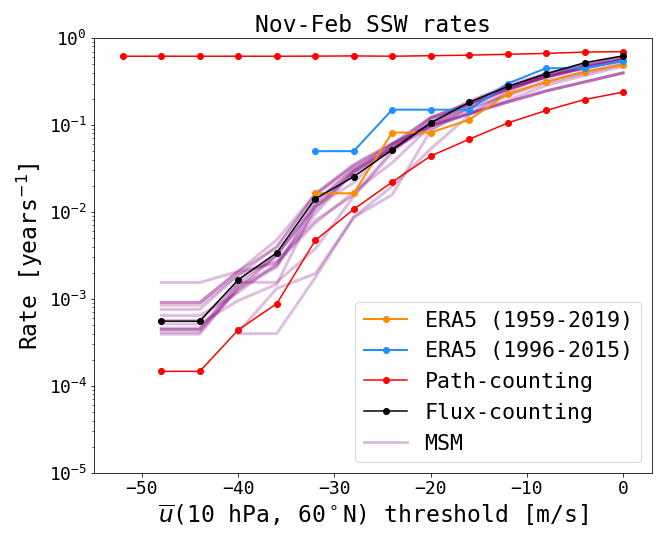

In [44]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]

extval_stats = pickle.load(open(join(filedict["results"]["extval"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
rate_e5 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = rate_s2.where(rate_s2 > 0)


fig,ax = plt.subplots(figsize=(10,8))
fig.set_facecolor("white")
handles = []
ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold [m/s]", fontsize=23)
ax.set_ylabel("Rate [years$^{-1}$]", fontsize=23)
ax.set_title(f"{t_thresh_string_list[i_tth]} SSW rates", fontsize=23)
ax.set_ylim([1e-5,1])
ax.set_xlim([u_thresh_list.min()-3, u_thresh_list.max()+3])
ax.set_xticks(np.arange(-50,1,10))

# --------------- Method 0: direct counting from ERA5 --------------
h, = ax.plot(
    rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), 
    color="darkorange", marker='o', linewidth=2, label="ERA5 (1959-2019)"
)
handles = [h] + handles
h, = ax.plot(
    rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), 
    color="dodgerblue", marker='o', linewidth=2, label="ERA5 (1996-2015)"
)
handles = [h] + handles
ax.legend(handles=handles[::-1], fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_0"), bbox_inches="tight")

# --------------- Method 1: upper and lower bounds from S2S ---------
ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='o')
h, = ax.plot(
    rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
    color="red", marker='o', label=r"Path-counting"
)
handles = [h] + handles
ax.legend(handles=handles[::-1], fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_1"), bbox_inches="tight")

# --------------- Method 2: direct estimate from S2S --------------
# Additionally plot Ed's estimate
h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="Flux-counting")
handles = [h] + handles
ax.legend(handles=handles[::-1], fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_2"), bbox_inches="tight")


# ---------------------- Method 3: DGA (one result at a time) -----------------------------
for max_delay in max_delay_list:
    for num_clusters in num_clusters_list:    
        dga_rates = pickle.load(
            open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                      f"dga_rates_{t_thresh[0]}-{t_thresh[1]}"), "rb")
        )["s2"]
        dga_rates[dga_rates==0] = np.nan
        h, = ax.plot(u_thresh_list, dga_rates, color='purple', linestyle='--', 
                     linewidth=3, label="MSM", zorder=-1, alpha=1)
        handles = [h] + handles
        ax.legend(handles=handles[::-1], fontsize="large", loc="lower right")
        fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_3_cl{num_clusters}_md{max_delay}"), bbox_inches="tight")
        # Remove it
        h.remove()
        handles.pop(0)

# ---------------- All DGA results together ---------------
for max_delay in max_delay_list:
    for num_clusters in num_clusters_list:    
        dga_rates = pickle.load(
            open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                      f"dga_rates_{t_thresh[0]}-{t_thresh[1]}"), "rb")
        )["s2"]
        dga_rates[dga_rates==0] = np.nan
        h, = ax.plot(u_thresh_list, dga_rates, color='purple', linestyle='-', 
                     linewidth=3, label="MSM", zorder=-1, alpha=0.25)
handles = [h] + handles
ax.legend(handles=handles[::-1], fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_3"), bbox_inches="tight")

# ----------------------- Method 4: LIM -----------------------------
if False:
    for src in ["e5","s2"]:
        h, = ax.plot(
            rate_lim[src]["u_thresh"].values, 
            rate_lim[src].isel(i_tth=i_tth).values, color=dispdict[src]["color"], 
            linestyle='--', linewidth=3, label=f"{dispdict[src]['abbrv']} LIM")
        handles = [h] + handles
    ax.legend(handles=handles, fontsize="large", loc="lower right")
    
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_4"), bbox_inches="tight")


TODO: plot some integrated error metric and plot it against the cluster number and delay.

# Find the important features

### Do a sparse linear regression over features. 

In [31]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]
num_clusters = num_clusters_opt
max_delay = max_delay_opt

delays = np.arange(max_delay)
szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "szn_stats_e5.nc"))
msm_info = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "msm_info"), "rb"))

t_bounds = [t_thresh[0], t_thresh[0]+30]


feats2regress = [f"ubar_{lev}_60_delay{d}" for lev in [10,100,500,850] for d in delays]
feats2regress_labels = [r"$\overline{u}$(%i hPa, 60$^\circ$N, t-%i)"%(lev,d) for lev in [10,100,500,850] for d in delays]
feats2regress += [f"vT_{lev}_{wn}_runavg10" for lev in [10,100,500,850] for wn in [0,1,2]]
feats2regress_labels += [r"$\overline{v'T'}$(%i hPa, 60$^\circ$N, wave-%i, 10-day mean)"%(lev,wn) for lev in [10,100,500,850] for wn in [0,1,2]]
stackmap = dict({"sample": ["t_init","member","t_sim"]})
X = (
    feat_tpt["s2"].sel(feature=feats2regress)
    .stack(stackmap).transpose("sample","feature")
)

In [38]:
# Store LASSO results in a dataarray
reg_coef = xr.DataArray(
    coords={"u_thresh": u_thresh_list, "feature": feats2regress, "target": ["committor","leadtime"]}, 
    dims=["u_thresh","feature","target"], data=np.nan)
reg_bias = xr.DataArray(
    coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]},
    dims=["u_thresh","target"], data=np.nan)
reg_rsq = xr.DataArray(
    coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]}, 
    dims=["u_thresh","target"], data=np.nan)

dec_imp = xr.DataArray(
    coords={"u_thresh": u_thresh_list, "feature": feats2regress, "target": ["committor","leadtime"]}, 
    dims=["u_thresh","feature","target"], data=np.nan)
dec_rsq = xr.DataArray(
    coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]}, 
    dims=["u_thresh","target"], data=np.nan)

for i_uth in range(1,len(u_thresh_list)):
    u_thresh = u_thresh_list[i_uth]
    print(f"Beginning regression in threshold {u_thresh}")
    feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
    dga_results = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))
    qp = dict({
        "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qp"]), #"e5": comm_e5.sel(sense="until"),
    })
    eta = dict({
        "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["leadtime"]["mean"]), #"e5": comm_e5.sel(sense="until"),
    })
    Y_qp = qp["s2"].stack(stackmap)
    Y_eta = eta["s2"].stack(stackmap)
    t_szn = feat_tpt["s2"].sel(feature="t_szn").stack(stackmap)

    idx2fit_candidates = np.where(
        (t_szn >= t_bounds[0]) * (t_szn < t_bounds[1])
        * np.all(np.isfinite(X.values), axis=1) * np.isfinite(Y_qp.values)
        * (Y_qp > 1e-6) * (1-Y_qp > 1e-6)
    )[0]
    if len(idx2fit_candidates) > 0:
        idx2fit = np.random.choice(idx2fit_candidates, size=min(1000,len(idx2fit_candidates)), replace=True)
        Y_transformed = dict({
            "committor":  np.log(Y_qp.values[idx2fit] / (1 - Y_qp.values[idx2fit])),
            "leadtime": np.log(Y_eta.values[idx2fit])
        })
        for target in ["committor","leadtime"]:
            # ----------- Lasso regression -----------
            reg = Lasso(alpha=0.05).fit(X.values[idx2fit], Y_transformed[target])
            reg_bias.loc[dict(u_thresh=u_thresh,target=target)] = reg.intercept_
            reg_coef.loc[dict(u_thresh=u_thresh,target=target)] = reg.coef_
            reg_rsq.loc[dict(u_thresh=u_thresh,target=target)] = reg.score(X.values[idx2fit], Y_transformed[target])
            # ------- Decision tree regression --------
            dec = tree.DecisionTreeRegressor(
                max_depth=6).fit(X.values[idx2fit], Y_transformed[target])
            dec_imp.loc[dict(u_thresh=u_thresh,target=target)] = dec.feature_importances_
            dec_rsq.loc[dict(u_thresh=u_thresh,target=target)] = dec.score(X.values[idx2fit], Y_transformed[target])

dectree = xr.Dataset(data_vars={"importance": dec_imp, "rsq": dec_rsq})
dectree.to_netcdf(join(filedict["results"]["dga"], "dectree.nc"))
lassreg = xr.Dataset(data_vars={"bias": reg_bias, "coef": reg_coef, "rsq": reg_rsq})
lassreg.to_netcdf(join(filedict["results"]["dga"], "lassreg.nc"))

Beginning regression in threshold -48
Beginning regression in threshold -44
Beginning regression in threshold -40
Beginning regression in threshold -36
Beginning regression in threshold -32
Beginning regression in threshold -28
Beginning regression in threshold -24
Beginning regression in threshold -20
Beginning regression in threshold -16
Beginning regression in threshold -12
Beginning regression in threshold -8
Beginning regression in threshold -4
Beginning regression in threshold 0


In [39]:
dectree = xr.open_dataset(join(filedict["results"]["dga"], "dectree.nc")).isel(u_thresh=slice(1,None))
lassreg = xr.open_dataset(join(filedict["results"]["dga"], "lassreg.nc")).isel(u_thresh=slice(1,None))

### Plot the importances, averaged over thresholds

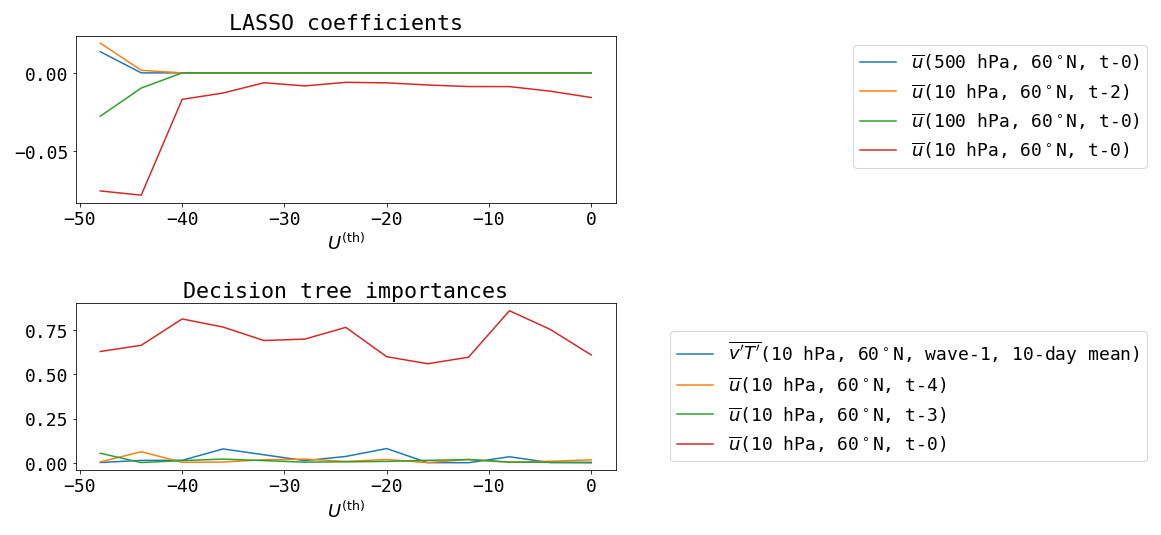

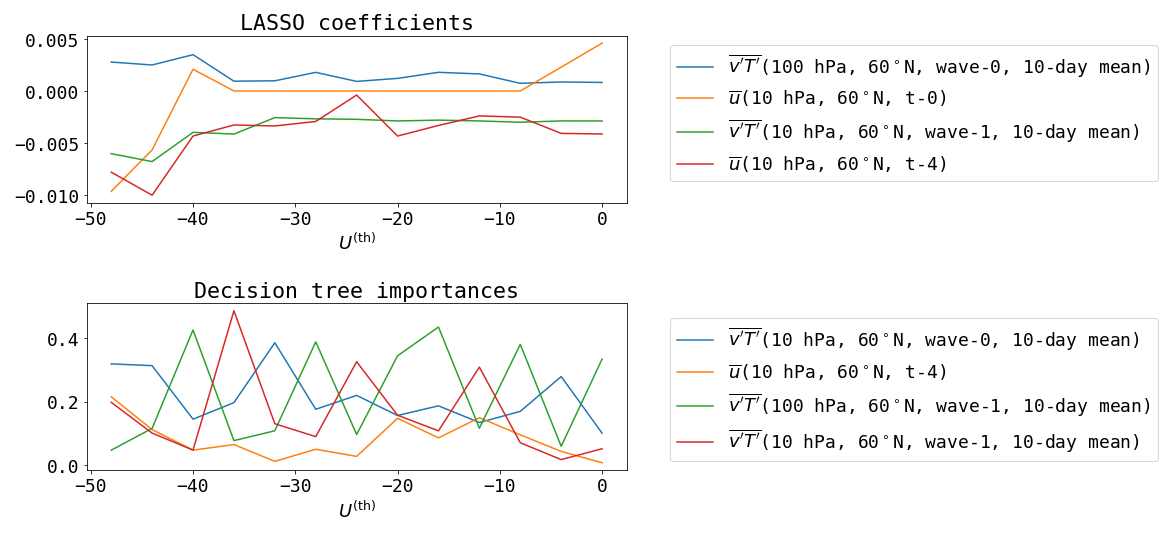

In [42]:
for target in ["committor","leadtime"]:
    # Top: feature importances
    # Bottom: skill & sparsity 
    fig,axes = plt.subplots(nrows=2,figsize=(12,8))
    fig.subplots_adjust(right=0.75,hspace=0.6)
    fig.set_facecolor("white")

    ax = axes[0]
    # LASSO
    lasso_leaders = (1.0*(np.abs(lassreg["coef"].sel(target=target,drop=True)))).mean(dim="u_thresh").argsort().values[-4:]
    handles = []
    for ll in lasso_leaders:
        h, = xr.plot.plot(lassreg["coef"].isel(feature=ll).sel(target=target), x="u_thresh", ax=ax, label=feats2regress_labels[ll])
        handles += [h]
    ax.legend(handles=handles, bbox_to_anchor=(2.0,1.0))
    ax.set_title("LASSO coefficients")
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    ax.set_ylabel("")

    # Decision tree 
    ax = axes[1]
    dectree_leaders = (1.0*(np.abs(dectree["importance"].sel(target=target,drop=True)) > 0)).mean(dim="u_thresh").argsort().values[-4:]
    handles = []
    for ll in dectree_leaders:
        h, = xr.plot.plot(dectree["importance"].isel(feature=ll).sel(target=target), x="u_thresh", ax=ax, label=feats2regress_labels[ll])
        handles += [h]
    ax.legend(handles=handles, loc="lower right", bbox_to_anchor=(2.0,0.0))
    ax.set_title("Decision tree importances")
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    ax.set_ylabel("")

    fig.savefig(join(filedict["results"]["dga"], f"regression_importances_{target}"))

### Plot the skill of the forecasting methods as a function of uthresh

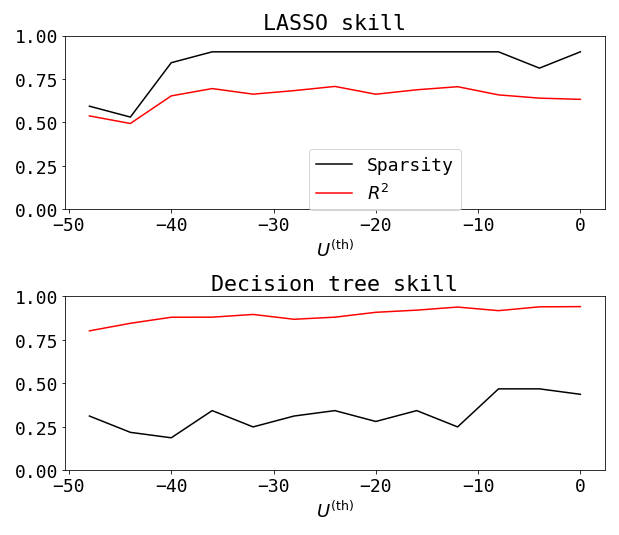

In [208]:
fig,axes = plt.subplots(nrows=2,figsize=(12,8))
fig.subplots_adjust(right=0.75,hspace=0.5)
fig.set_facecolor("white")

ax = axes[0]
h0, = xr.plot.plot((lassreg["coef"]==0).mean(dim="feature"), x="u_thresh", ax=ax, color="black", label="Sparsity")
h1, = xr.plot.plot(lassreg["rsq"], x="u_thresh", ax=ax, color="red", label=r"$R^2$")
ax.legend(handles=[h0,h1], bbox_to_anchor=(0.75,0.4))
ax.set_ylim([0,1])
ax.set_title("LASSO skill")
ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
ax.set_ylabel("")
ax.xaxis.set_tick_params(which="both", labelbottom=True)

ax = axes[1]
h0, = xr.plot.plot((dectree["importance"]==0).mean(dim="feature"), x="u_thresh", ax=ax, color="black", label="Sparsity")
h1, = xr.plot.plot(dectree["rsq"], x="u_thresh", ax=ax, color="red", label=r"$R^2$")
#ax.legend(handles=[h0,h1], bbox_to_anchor=(1.25,1.0))
ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
ax.set_ylim([0,1])
ax.set_ylabel("")
ax.set_title("Decision tree skill")

fig.savefig(join(filedict["results"]["dga"], "regression_skills"))

Which features contributed the most?

In [45]:
target_names = dict({"leadtime": r"$\eta^+$", "committor": r"$q^+$"})
for i_uth in range(lassreg["u_thresh"].size):
    for target in "committor","leadtime":
        fig,axes = plt.subplots(figsize=(10,15), ncols=2, sharey=True)
        fig.subplots_adjust(top=0.9)
        fig.set_facecolor("white")    
        fig.suptitle(r"%s for $U^{(\mathrm{th})}=%i$ m/s"%(
            target_names[target], lassreg["u_thresh"].values[i_uth]))
        ax = axes[0]
        ax.barh(feats2regress_labels, lassreg["coef"].isel(u_thresh=i_uth).sel(target=target))
        ax.set_title(r"LASSO ($R^2=%.2f$)"%(lassreg["rsq"].isel(u_thresh=i_uth).sel(target=target)))
        ax.axvline(x=0, color="black", linestyle="--")
        ax = axes[1]
        ax.barh(feats2regress_labels, dectree["importance"].isel(u_thresh=i_uth).sel(target=target))
        ax.yaxis.set_visible("False")
        ax.set_title("Decision Tree ($R^2=%.2f$)"%(lassreg["rsq"].isel(u_thresh=i_uth).sel(target=target)))
        fig.savefig(join(filedict["results"]["shared"], f"coefs_{target}_uth{lassreg['u_thresh'].values[i_uth]}"))
        plt.close(fig)


## Plot some pictures of the committor and lead time.

In [210]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

lead time PMF

In [211]:
i_tth = 1
num_clusters = 150
max_delay = 5
t_thresh = t_thresh_list[i_tth]
t_thresh_str = ([
    (
        datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
    ).strftime("%b %d")
    for i in range(2)]
)

t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
vmin = <xarray.DataArray ()>
array(3.74882751e-08)
Coordinates:
    feature  <U14 't_szn'
levels = [3.74882751e-08 3.17803390e-07 2.69414889e-06 2.28393985e-05
 1.93618891e-04 1.64138627e-03 1.39147005e-02 1.17960589e-01
 1.00000000e+00]
vmin = <xarray.DataArray ()>
array(3.74882751e-08)
Coordinates:
    feature  <U14 't_szn'
levels = [3.74882751e-08 3.17803390e-07 2.69414889e-06 2.28393985e-05
 1.93618891e-04 1.64138627e-03 1.39147005e-02 1.17960589e-01
 1.00000000e+00]
vmin = <xarray.DataArray ()>
array(3.74882751e-08)
Coordinates:
    feature  <U14 't_szn'
levels = [3.74882751e-08 3.17803390e-07 2.69414889e-06 2.28393985e-05
 1.93618891e-04 1.64138627e-03 1.39147005e-02 1.17960589e-01
 1.00000000e+00]
vmin = 0.1481220391218053
levels = [0.14812204 0.1693868  0.19370438 0.22151304 0.25331399 0.28968036
 0.33126757 0.37882515 0.4332102 ]
vmin = 0.0001982657178375531
levels = [1.982657

KeyboardInterrupt: 

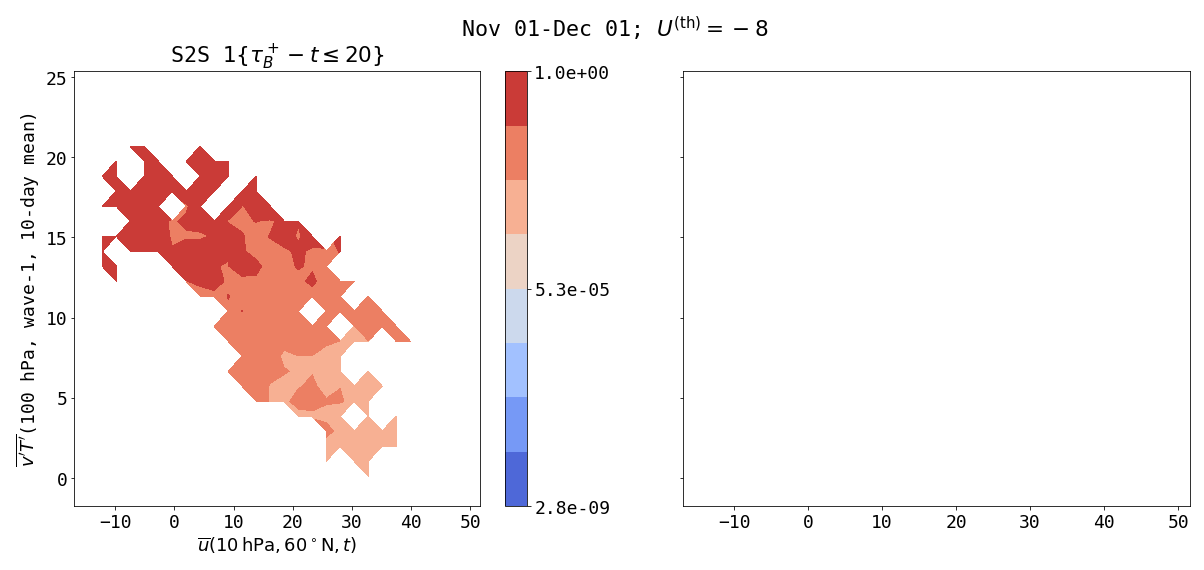

In [46]:
qplimited_labels = dict({"s2": "S2S", "dga": "MSM"})
for tau_max in [20]:
    for i_uth in [9,11,13]: #np.arange(1,len(u_thresh_list),4):
        u_thresh = u_thresh_list[i_uth]
        szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "szn_stats_e5.nc"))
        msm_info = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "msm_info"), "rb"))


        dga_results = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))
        feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
        ab_tag_e5 = feat_strat.ab_test(feat_tpt["e5"])
        cej_e5 = feat_strat.cotton_eye_joe(feat_tpt["e5"], ab_tag_e5, "timechunks")
        comm_e5 = feat_strat.estimate_empirical_committor(cej_e5)
        ab_tag_s2 = feat_strat.ab_test(feat_tpt["s2"])
        cej_s2 = feat_strat.cotton_eye_joe(feat_tpt["s2"], ab_tag_s2, "timesteps")
        comm_s2 = feat_strat.estimate_empirical_committor(cej_s2)


        qp = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qp"]), 
            "e5": comm_e5.sel(sense="until"),
            "s2": comm_s2.sel(sense="until"),
        })
        qm = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qm"]), 
            "e5": comm_e5.sel(sense="since"),
            "s2": comm_s2.sel(sense="since"),
        })
        pi = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["pi"], density_flag=True), 
            "e5": xr.ones_like(qm["e5"]),
            "s2": xr.ones_like(qm["s2"]),
        })
        eta = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["leadtime"]["mean"]), 
        })
        prob_ssw_46 = [np.nansum(tau_pmf[:tau_max+1], axis=0) for tau_pmf in dga_results["tau_pmf"]]
        qp_limited = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], prob_ssw_46), 
            "e5": 1.0*(cej_e5.sel(sense="until",state="B") <= tau_max),
            "s2": 1.0*(cej_s2.sel(sense="until",state="B") <= tau_max),
        })

        qp_vmin = min(qp["dga"].where(qp["dga"] > 0).min(), qp["s2"].where(qp["s2"] > 0).min())
        qp_limited_vmin = min(qp_limited["dga"].where(qp_limited["dga"] > 0).min(), qp_limited["s2"].where(qp_limited["s2"] > 0).min())
        qp_limited_vmax = max(qp_limited["dga"].max(), qp_limited["s2"].max())

        for combo in [0,1,6,14,15,16]:
            if combo == 0:
                feat_names = ["vT_10_0_runavg10","vT_10_1_runavg10"]
                feat_labels = [r"$\overline{v'T'}$(10 hPa, wave-0)", r"$\overline{v'T'}$(10 hPa, wave-1)"]
                t_bounds = t_thresh[0]+0, t_thresh[0]+30                
            elif combo == 1:
                feat_names = ["vT_100_0_runavg10","vT_100_1_runavg10"]
                feat_labels = [r"$\overline{v'T'}$(100 hPa, wave-0)", r"$\overline{v'T'}$(100 hPa, wave-1)"]
                t_bounds = t_thresh[0]+0, t_thresh[0]+30    
            elif combo == 6:
                feat_names = ["t_szn","ubar_10_60_delay0"]
                feat_labels = [r"", r"$\overline{u}(10\,\mathrm{hPa},60^\circ\mathrm{N},t)$"]
                t_bounds = t_thresh[0], t_thresh[1]   
            elif combo == 14:
                feat_names = ["ubar_10_60_delay0","vT_10_1_runavg10"]
                feat_labels = [r"$\overline{u}(10\,\mathrm{hPa},60^\circ\mathrm{N},t)$", r"$\overline{v'T'}$(10 hPa, wave-1, 10-day mean)"]
                t_bounds = t_thresh[0]+0, t_thresh[0]+30
            elif combo == 15:
                feat_names = ["ubar_10_60_delay0","vT_100_1_runavg10"]
                feat_labels = [r"$\overline{u}(10\,\mathrm{hPa},60^\circ\mathrm{N},t)$", r"$\overline{v'T'}$(100 hPa, wave-1, 10-day mean)"]
                t_bounds = t_thresh[0]+0, t_thresh[0]+30
            elif combo == 16:
                feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
                feat_labels = [r"$\overline{u}(100\,\mathrm{hPa},60^\circ\mathrm{N},t)$", r"$\overline{u}(500\,\mathrm{hPa},60^\circ\mathrm{N},t)$"]
                t_bounds = t_thresh[0]+0, t_thresh[0]+30
                
            t_bounds = list(t_bounds)

            # ------------------- Expected lead time ----------------------

            fig,axes = plt.subplots(ncols=2, figsize=(20,8), sharey=True, sharex=True)
            # Make a title that shows the time range
            date_bounds_str = ([
                (
                    datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                    + datetime.timedelta(days=int(t_bounds[i]))
                ).strftime("%b %d")
                for i in range(2)]
            )

            fig.suptitle(r"%s-%s; $U^{\mathrm{(th)}}=%i$" % (date_bounds_str[0],date_bounds_str[1],u_thresh))
            fig.set_facecolor('white')
            for i_src, src in enumerate(["dga"]):
                stackmap = {"sample": ("t_init","member","t_sim")}
                field = eta[src].stack(stackmap).to_numpy().flatten()
                weight = pi[src].stack(stackmap).to_numpy().flatten()
                cond = (
                    (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                    * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
                    #* (feat_tpt[src]["member"] == 1) 
                )
                cond = (
                    (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                    * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
                    #* (feat_tpt[src]["member"] == 1) 
                )

                features = np.array([
                    feat_tpt["s2"].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
                    feat_tpt["s2"].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
                ]).T

                ax = axes[i_src]
                tpt_utils.plot_field_2d(
                    field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                    stat_name="mean", 
                    vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                    pcolor_flag=False, contour_flag=True, cbar_flag=True
                )
                ax.set_title(r"$\eta_B^+$")
                ax.set_xlabel(feat_labels[0])
                ax.set_ylabel(feat_labels[1])
                ax.xaxis.set_tick_params(which="both", labelbottom=True)
                ax.yaxis.set_tick_params(which="both", labelbottom=True)

                if feat_names[0] == "t_szn":
                    xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                    ax.set_xlabel("")
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticklabels)
                
                
            fig.savefig(
                join(filedict["results"]["shared"], f"eta_combo{combo}_{date_bounds_str[0]}-{date_bounds_str[1]}_uth{u_thresh}"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)
  
            # ------------------- Committor & density ----------------------

            # ------------------- Lead time <= tau_max ----------------------

            fig,axes = plt.subplots(ncols=2, figsize=(20,8), sharey=True, sharex=True)
            # Make a title that shows the time range
            date_bounds_str = ([
                (
                    datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                    + datetime.timedelta(days=int(t_bounds[i]))
                ).strftime("%b %d")
                for i in range(2)]
            )

            fig.suptitle(r"%s-%s; $U^{\mathrm{(th)}}=%i$" % (date_bounds_str[0],date_bounds_str[1],u_thresh))
            fig.set_facecolor('white')
            for i_src, src in enumerate(["s2","dga"]):
                # Two committors to plot: one according to ERA5, and one according to S2S 
                stackmap = {"sample": ("t_init","member","t_sim")}
                field = qp_limited[src].stack(stackmap).to_numpy().flatten()
                weight = pi[src].stack(stackmap).to_numpy().flatten()
                cond = (
                    (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                    * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
                    #* (feat_tpt[src]["member"] == 1) 
                )
                cond = (
                    (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                    * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
                    #* (feat_tpt[src]["member"] == 1) 
                )

                features = np.array([
                    feat_tpt["s2"].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
                    feat_tpt["s2"].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
                ]).T

                ax = axes[i_src]
                tpt_utils.plot_field_2d(
                    field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                    stat_name="mean", 
                    vmin=qp_limited_vmin, vmax=qp_limited_vmax, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                    pcolor_flag=False, contour_flag=True, cbar_flag=True
                )
                ax.set_title(r"%s $1\{\tau_B^+-t\leq %i\}$"%(qplimited_labels[src],tau_max))
                ax.set_xlabel(feat_labels[0])
                ax.set_ylabel(feat_labels[1])
                ax.xaxis.set_tick_params(which="both", labelbottom=True)
                ax.yaxis.set_tick_params(which="both", labelbottom=True)

                if feat_names[0] == "t_szn":
                    xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                    ax.set_xlabel("")
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticklabels)
                
                
            fig.savefig(
                join(filedict["results"]["shared"], f"qplimited_combo{combo}_taumax{tau_max}_{date_bounds_str[0]}-{date_bounds_str[1]}_uth{u_thresh}"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)
  
            # ------------------- Committor & density ----------------------
    
            src = "dga"

            fig,axes = plt.subplots(ncols=2, figsize=(20,8), sharey=True, sharex=True)
            # Make a title that shows the time range
            date_bounds_str = ([
                (
                    datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                    + datetime.timedelta(days=int(t_bounds[i]))
                ).strftime("%b %d")
                for i in range(2)]
            )

            fig.suptitle(r"%s-%s; $U^{\mathrm{(th)}}=%i$" % (date_bounds_str[0],date_bounds_str[1],u_thresh))
            fig.set_facecolor('white')
            stackmap = {"sample": ("t_init","member","t_sim")}
            field = qp[src].stack(stackmap).to_numpy().flatten()
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            cond = (
                (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
                #* (feat_tpt[src]["member"] == 1) 
            )
            features = np.array([
                feat_tpt["s2"].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
                feat_tpt["s2"].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
            ]).T

            # Committor
            ax = axes[0]
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="mean", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            ax.set_title(r"Committor")
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)
            if feat_names[0] == "t_szn":
                xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticklabels)
            # Density
            ax = axes[1]
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="weightsum", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.magma, logscale=True, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            ax.set_title(r"Density")
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)
            if feat_names[0] == "t_szn":
                xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticklabels)

            fig.savefig(
                join(filedict["results"]["shared"], f"qpandpi_combo{combo}_taumax{tau_max}_{date_bounds_str[0]}-{date_bounds_str[1]}_uth{u_thresh}"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)

t_sim.shape = (22280,)


Exception: Inconsistent shapes. field: ((44560,)), features: ((22280, 2)), weights: ((22280,))

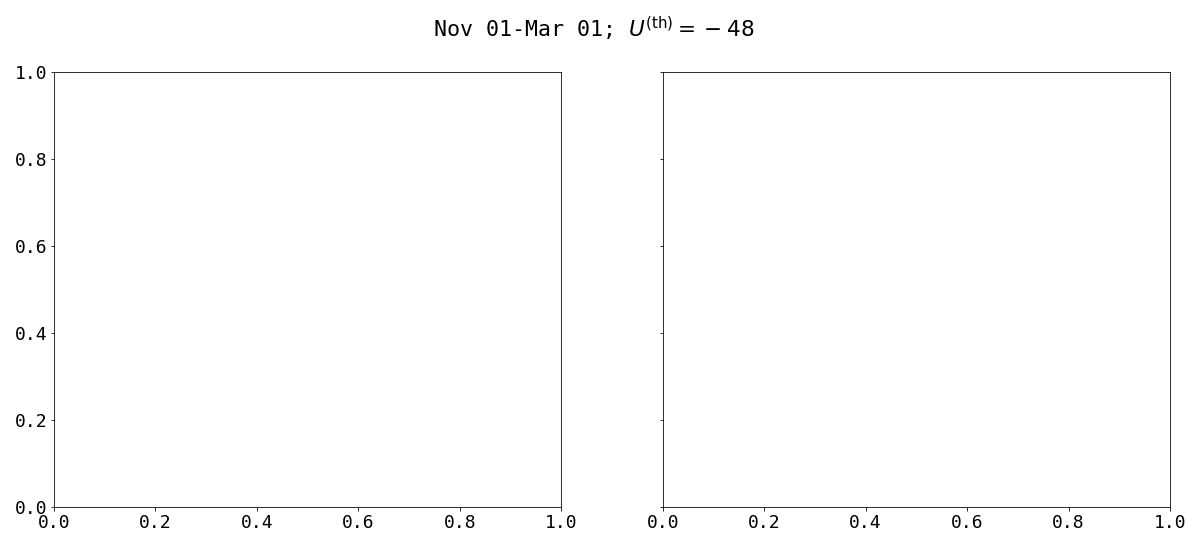

In [155]:
        # ------------------- Density ----------------------
        print(f"Starting to plot density")

        fig,axes = plt.subplots(ncols=2, figsize=(20,8), sharey=True, sharex=True)
        # Make a title that shows the time range
        date_bounds_str = ([
            (
                datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                + datetime.timedelta(days=int(t_bounds[i]))
            ).strftime("%b %d")
            for i in range(2)]
        )

        fig.suptitle(r"%s-%s; $U^{\mathrm{(th)}}=%i$" % (date_bounds_str[0],date_bounds_str[1],u_thresh))
        fig.set_facecolor('white')
        for i_src, src in enumerate(["e5","s2"]):
            # Two committors to plot: one according to ERA5, and one according to S2S 
            stackmap = {"sample": ("t_init","member","t_sim")}
            field = qp[src].stack(stackmap).to_numpy().flatten()
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            cond = (
                (feat_tpt[src].sel(feature="t_szn") > t_bounds[0]) 
                * (feat_tpt[src].sel(feature="t_szn") < t_bounds[1])
                #* (feat_tpt[src]["member"] == 1) 
            )
            features = np.array([
                feat_tpt[src].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
                feat_tpt[src].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
            ]).T

            ax = axes[i_src]
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_names, 
                stat_name="mean", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            ax.set_title(f"{dispdict[src]['abbrv']} Committor")
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)

        fig.savefig(
            join(filedict["results"]["shared"], f"pi_combo{combo}_{date_bounds_str[0]}-{date_bounds_str[1]}_uth{u_thresh}"
                 .replace(" ","").replace(".","p")))
        # ------------------- Committor ----------------------

        fig,axes = plt.subplots(ncols=2, figsize=(20,8), sharey=True, sharex=True)
        # Make a title that shows the time range
        date_bounds_str = ([
            (
                datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                + datetime.timedelta(days=int(t_bounds[i]))
            ).strftime("%b %d")
            for i in range(2)]
        )

        fig.suptitle(r"%s-%s; $U^{\mathrm{(th)}}=%i$" % (date_bounds_str[0],date_bounds_str[1],u_thresh))
        fig.set_facecolor('white')
        for i_src, src in enumerate(["e5","s2"]):
            # Two committors to plot: one according to ERA5, and one according to S2S 
            stackmap = {"sample": ("t_init","member","t_sim")}
            field = qp[src].stack(stackmap).to_numpy().flatten()
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            cond = (
                (feat_tpt[src].sel(feature="t_szn") > t_bounds[0]) 
                * (feat_tpt[src].sel(feature="t_szn") < t_bounds[1])
                #* (feat_tpt[src]["member"] == 1) 
            )
            features = np.array([
                feat_tpt[src].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
                feat_tpt[src].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
            ]).T

            ax = axes[i_src]
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_names, 
                stat_name="mean", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            ax.set_title(f"{dispdict[src]['abbrv']} Committor")
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)


        fig.savefig(
            join(filedict["results"]["shared"], f"qp_combo{combo}_{date_bounds_str[0]}-{date_bounds_str[1]}_uth{u_thresh}"
                 .replace(" ","").replace(".","p")))

In [161]:
2080*10*47

977600

In [160]:
features.shape

(22280, 2)

### Measure distribution of committors at each time window

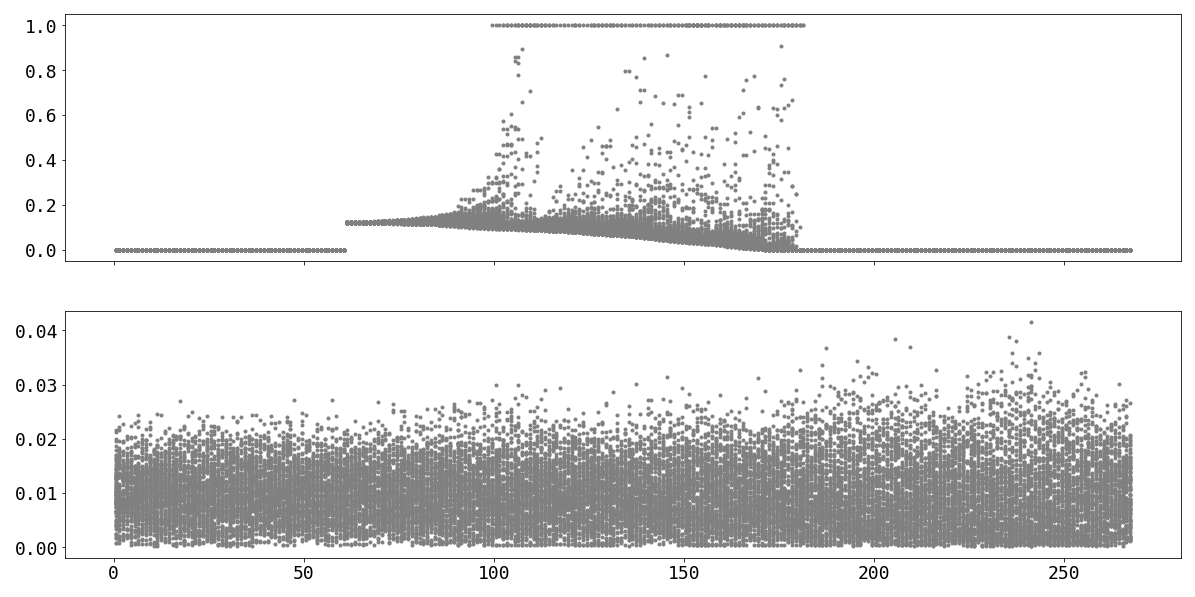

In [72]:
fig,axes = plt.subplots(nrows=2,figsize=(20,10), sharex=True)
for i_win in range(len(dga_results["qp"])):
    n_clust = len(dga_results["qp"][i_win])
    axes[0].scatter(
        szn_stats_e5.t_szn_cent.values[i_win]*np.ones(n_clust), 
        dga_results["qp"][i_win], marker='.', color='gray', alpha=1,
    )
    axes[1].scatter(
        szn_stats_e5.t_szn_cent.values[i_win]*np.ones(n_clust), 
        dga_results["pi"][i_win], marker='.', color='gray', alpha=1,
    )

# Method 2.5: fit a GEV distribution to this data 

### TBD

# Method 3: running a LIM 

Here we construct a linear inverse model (a.k.a., (E)DMD) from the features we've chosen. We will test its robustness to lag time and ensure it varies smoothly with the seasonal cycle. After that, we will possibly incorporate the corresponding modes into the feature vector for DGA. 

In [ ]:
ubar_names = [f"ubar_{lev}_60_delay{d}" for d in [0] for lev in [10,100,500,850]]
vT_1_names = [f"vT_{lev}_1_runavg10" for lev in [10,100,500,850]]
vT_2_names = [f"vT_{lev}_2_runavg10" for lev in [10,100,500,850]]
ubar_delay_names = [f"ubar_10_60_delay{d}" for d in range(15)]
#lim_feature_names = ubar_names + vT_1_names + vT_2_names
lim_feature_names = ubar_delay_names
feat_msm = feat_tpt["s2"].sel(feature=lim_feature_names)
feat_msm_e5 = feat_tpt["e5"].sel(feature=lim_feature_names)

In [ ]:
szn_stats_e5 = feat_strat.get_seasonal_statistics(feat_msm_e5, feat_tpt["e5"].sel(feature="t_szn"))
# Replace the mean with first four harmonics
ssm = szn_stats_e5["mean"].transpose("feature","t_szn_cent")
ssmhat = np.fft.fft(ssm.values, axis=1)
ssmhat[:,5:-5] = 0
ssmooth = np.fft.ifft(ssmhat, axis=1).real
ssm[:] = ssmooth

In [ ]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [ ]:
feat_lim = dict()
for src in ["s2","e5"]:
    feat_lim[src] = feat_tpt[src].sel(feature=lim_feature_names)

In [ ]:
lim = dict()
for src in ["s2","e5"]:
    lim[src] = feat_strat.build_lim(
        feat_lim[src], szn_stats_e5, feat_all[src]["time_observable"], 
        max_delay, demean=True, max_lag=1
    )

Simulate the LIM!

In [ ]:
# Sample random initial conditions
win_init = 0
win_fin = 260
szn_window_e5 = (feat_all["e5"]["time_observable"].sel(feature="t_szn") / feat_strat.dt_szn).astype(int)
idx_init = np.where(szn_window_e5.values == win_init)
X_init = (
    feat_lim["e5"].transpose("t_init","member","t_sim","feature")
    - szn_stats_e5["mean"].isel(t_szn_cent=win_init)
).values[idx_init]

In [ ]:
# Run both LIMs 
X_sim = dict()
for src in ["e5","s2"]:
    X_sim[src] = xr.DataArray(
        coords={
            "t_szn_cent": szn_stats_e5["t_szn_cent"].values[win_init:win_fin+1], 
            "feature": feat_lim["e5"]["feature"],
            "sample": np.arange(30000),
        },
        dims=["t_szn_cent","sample","feature"],
        data=np.nan,
    )
    idx_sim = np.random.choice(np.arange(len(X_init)), size=X_sim[src]["sample"].size, replace=True)
    X_sim[src][dict(t_szn_cent=0)] = X_init[idx_sim]

    for i_win in range(win_fin-win_init):
        xi = np.random.randn(X_sim[src]["sample"].size, X_sim[src]["feature"].size)
        forcing = xi @ (lim[src]["sigma"].isel(t_szn_cent=win_init+i_win).values).T
        G = lim[src]["G"].isel(t_szn_cent=win_init+i_win).values
        X_sim[src][dict(t_szn_cent=i_win+1)] = X_sim[src].isel(t_szn_cent=i_win).values @ G.T + forcing

Save the LIM and X_sim

In [ ]:
for src in ["e5","s2"]:
    lim[src].to_netcdf(join(filedict["results"]["dir"], f"lim_{src}.nc"))
    X_sim[src].to_netcdf(join(filedict["results"]["dir"], f"X_sim_{src}.nc"))

In [ ]:
feat = "ubar_10_60_delay0"
fig,axes = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
sources = ["e5","s2"]
for i_src,src in enumerate(["e5","s2"]):
    ax = axes[i_src]
    ax.plot(szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    for samp in range(500): #X_sim["sample"].values:
        ax.plot(
            X_sim[src].sel(sample=samp,feature=feat) + szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)),
            color='dodgerblue', alpha=0.5
        )
    ax.plot(szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.plot(szn_stats_e5["min"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.plot(szn_stats_e5["max"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.set_title(f"{dispdict[src]['abbrv']} LIM")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("$\overline{u}$(10 hPa, 60$^\circ$N)")

Compute the rates inferred from this model.

In [ ]:
rate_lim = dict()
for src in ["e5","s2"]:
    rate_lim[src] = xr.DataArray(
        coords={"i_tth": range(len(t_thresh_list)), "u_thresh": u_thresh_list},
        dims=["i_tth","u_thresh"],
        data=np.nan
    )
    for i_tth in range(len(t_thresh_list)):
        t_thresh = t_thresh_list[i_tth]
        lim_umin = (
            (X_sim[src] + szn_stats_e5["mean"])
            .sel(feature="ubar_10_60_delay0",t_szn_cent=slice(t_thresh[0],t_thresh[1]))
        ).min(dim="t_szn_cent")
        for uth in rate_lim[src]["u_thresh"].values:
            rate_lim[src].loc[dict(i_tth=i_tth,u_thresh=uth)] = np.mean(lim_umin <= uth)
    rate_lim[src] = rate_lim[src].where(rate_lim[src] > 0)

rate_lim_ds = xr.Dataset(data_vars=rate_lim)
rate_lim_ds.to_netcdf(join(filedict["results"]["dir"], f"rate_lim.nc"))

In [ ]:
i_tth = 0
t_thresh = t_thresh_list[i_tth]
extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
rate_e5 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

fig,axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)
fig.set_facecolor("white")
axes[1].yaxis.set_tick_params(labelbottom=True)

# First plot: extreme values
ax = axes[0]
labels = {"e5": "ERA5 (61 yr)", "s2": "S2S (20 yr)", "linear_model": "Linear model"}
zorders = {"e5": 0, "s2": 1, "linear_model": -1}
handles = []
for src in ["e5","s2","linear_model"]:
    idx, = np.where(extval_stats[src]["umin"] < 0)
    order = np.argsort(extval_stats[src]["umin"][idx])
    h, = ax.plot(
        extval_stats[src]["umin"][idx][order], extval_stats[src]["rate_lower"][idx][order], 
        color=dispdict[src]["color"],
        marker='.', label=labels[src], zorder=zorders[src]
    ) 
    handles += [h]


ax.legend(handles=handles, fontsize="small", loc="lower right")
ax.set_xlabel("Minimum $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_ylabel("Rate [years$^{-1}$]")
ax.set_yscale("log")
ax.set_title("Extreme value estimate")

# Second plot: rates
ax = axes[1]
handles = []
rate_s2 = rate_s2.where(rate_s2 > 0)
#colors = ["red", "purple", "orange"]
ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='.')
h, = ax.plot(
    rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
    color="red", marker='.', label=r"S2S (20 yr) bounds"
)
handles += [h]
# Additionally plot ERA5 only
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), color="orange", marker='.', label="ERA5 (61 yr)")
handles += [h]
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), color="dodgerblue", marker='.', label="ERA5 (20 yr)")
handles += [h]

# Additionally plot Ed's estimate
h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="direct")
handles += [h]

# Additionally plot the LIM estimate
for src in ["e5","s2"]:
    h, = ax.plot(
        rate_lim[src]["u_thresh"].values, 
        rate_lim[src].isel(i_tth=i_tth).values, color=dispdict[src]["color"], 
        linestyle='--', label=f"{dispdict[src]['abbrv']} LIM")
    handles += [h]



ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
ax.legend(handles=handles, fontsize="small")
ax.set_title("Path counting bounds")
ax.set_ylim([1e-5,1])

fig.subplots_adjust(top=0.85)
fig.suptitle(t_thresh_string_list[i_tth], y=0.98, fontsize=25)

Picture the committor from the LIM

In [ ]:
i_tth = 1
uth = 0
src = "e5"
t_thresh = t_thresh_list[i_tth]
lim_umin = (
    (X_sim[src] + szn_stats_e5["mean"])
    .sel(feature="ubar_10_60_delay0",t_szn_cent=slice(t_thresh[0],t_thresh[1]))
).min(dim="t_szn_cent")
lim_qp = xr.ones_like(X_sim[src] + szn_stats_e5["mean"]) * (lim_umin < uth)

In [ ]:
lim_qp.dims

In [ ]:
feat_names = ["ubar_10_60_delay0"]

fig,ax = plt.subplots()
fig.suptitle(f"Days {t_bounds[0]}-{t_bounds[1]}")
fig.set_facecolor('white')
stackmap = {"snapshot": ("t_szn_cent","sample")}
field = lim_qp[src].stack(stackmap).to_numpy().flatten()
weight = np.ones_like(lim_qp[src]).stack(stackmap).to_numpy().flatten()
cond = (lim_qp.sel(feature="t_szn_cent") > t_bounds[0]) * (lim_qp.sel(feature="t_szn_cent") < t_bounds[1])
features = np.array([
    lim_qp.where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
    lim_qp.where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
]).T

ax = axes[0,i_src]
tpt_utils.plot_field_2d(
    field, weight, features, fig=fig, ax=ax, feat_names=feat_names, 
    stat_name="mean", 
    vmin=0, vmax=1, shp=[30,30], cmap=plt.cm.coolwarm
)
ax.set_title(f"{dispdict[src]['abbrv']} Committor")